In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '../software')
sys.path.insert(0, '../firmware')

In [2]:

import pandas
import seaborn
import numpy
np = numpy

from analysis import load_files

In [3]:

data = load_files('../data/one', fixup_shape=True)
print(data.shape)
data.head(5)

(1840, 23)


,ch_FZ,ch_FY,ch_FXL,ch_NIR,ch_VIS1_TL,ch_VIS1_BR,ch_F2,ch_F3,ch_F4,ch_F6,...,ch_F7,ch_F8,ch_F5,ch_VIS3_TL,ch_VIS3_BR,datapoint,filename,experiment,lux,colortemp
0,1571,5034,5773,1670,7591,17984,1333,2034,2864,7309,...,5959,1795,1750,7589,17984,0,one_2500k_309lux.npy,one,309,2500
1,1571,5034,5773,1670,7592,17984,1333,2032,2862,7306,...,5961,1794,1750,7592,17980,1,one_2500k_309lux.npy,one,309,2500
2,1571,5037,5775,1670,7593,17984,1334,2032,2863,7307,...,5964,1796,1752,7595,17984,2,one_2500k_309lux.npy,one,309,2500
3,1572,5038,5773,1670,7596,17984,1333,2032,2862,7308,...,5963,1795,1750,7593,17981,3,one_2500k_309lux.npy,one,309,2500
4,1572,5040,5776,1671,7595,17982,1333,2035,2863,7307,...,5960,1795,1751,7592,17979,4,one_2500k_309lux.npy,one,309,2500


In [4]:
#sampled = data.groupby('filename', group_keys=False).sample(frac=1.0)
sampled = data.groupby('filename', group_keys=False).sample(frac=0.10)
#sampled = data.groupby('filename', group_keys=False).apply(lambda df: df.head(7).tail(1))
avg = sampled.groupby('filename').agg('median', numeric_only=True)
#avg = data.groupby('filename').agg('median', numeric_only=True)
avg.head()

,ch_FZ,ch_FY,ch_FXL,ch_NIR,ch_VIS1_TL,ch_VIS1_BR,ch_F2,ch_F3,ch_F4,ch_F6,...,ch_VIS2_BR,ch_F1,ch_F7,ch_F8,ch_F5,ch_VIS3_TL,ch_VIS3_BR,datapoint,lux,colortemp
filename,,,,,,,,,,,,,,,,,,,,,
one_2500k_100lux.npy,274.0,1206.0,1518.5,148.5,2131.5,17977.0,86.0,271.5,560.0,2061.0,...,17975.5,25.0,1536.0,208.0,264.5,2130.5,17977.5,14.0,100.0,2500.0
one_2500k_1lux.npy,5.0,11.0,10.0,16.0,19.0,587.5,2.5,5.0,8.0,13.0,...,587.5,1.0,13.0,9.0,3.0,19.0,587.5,9.5,1.0,2500.0
one_2500k_204lux.npy,737.5,2751.0,3311.5,614.5,4507.5,17980.5,457.5,856.5,1417.0,4350.5,...,17977.0,367.0,3380.0,720.0,777.0,4507.0,17982.0,13.0,204.0,2500.0
one_2500k_309lux.npy,1571.5,5038.0,5775.5,1670.0,7594.0,17978.0,1333.5,2033.5,2863.5,7307.0,...,17984.0,1264.0,5962.0,1794.5,1751.0,7592.0,17981.0,15.0,309.0,2500.0
one_2500k_408lux.npy,2431.0,7323.5,8194.5,2784.0,10597.5,17984.0,2265.0,3259.0,4331.0,10182.0,...,17981.5,2228.5,8515.5,2919.5,2760.0,10592.0,17983.0,14.0,408.0,2500.0


Fitting 5 folds for each of 25 candidates, totalling 125 fits

Metrics Comparison:
Metric                    Train        Test         Difference  
-----------------------------------------------------------------
R² Score                  0.9833       0.9842       0.0009      
RMSE                      30.6408      18.7751      11.8657     
Mean Absolute Error       24.0526      14.9395      9.1131      
Sample Size               71           21          


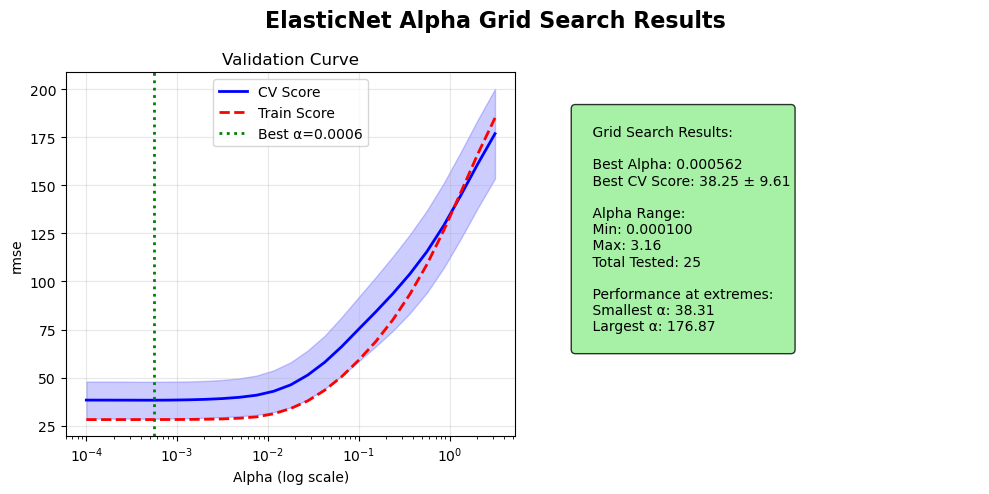

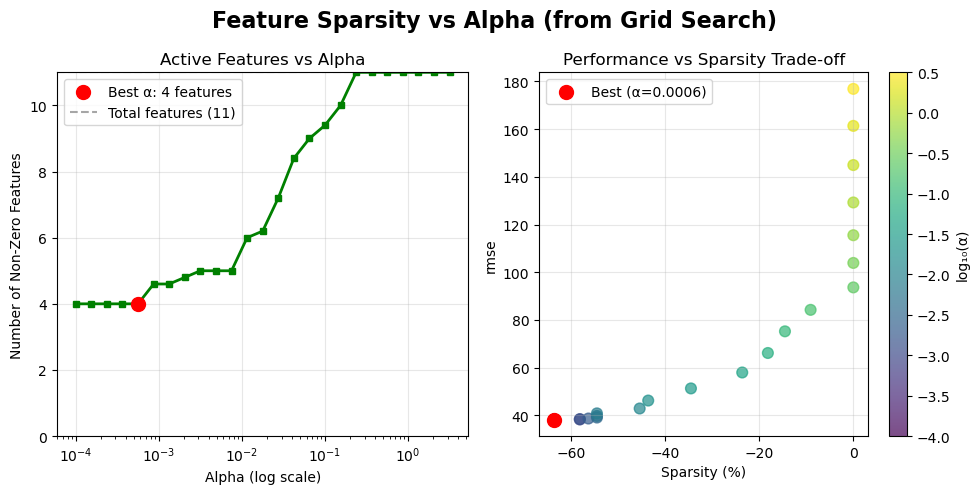

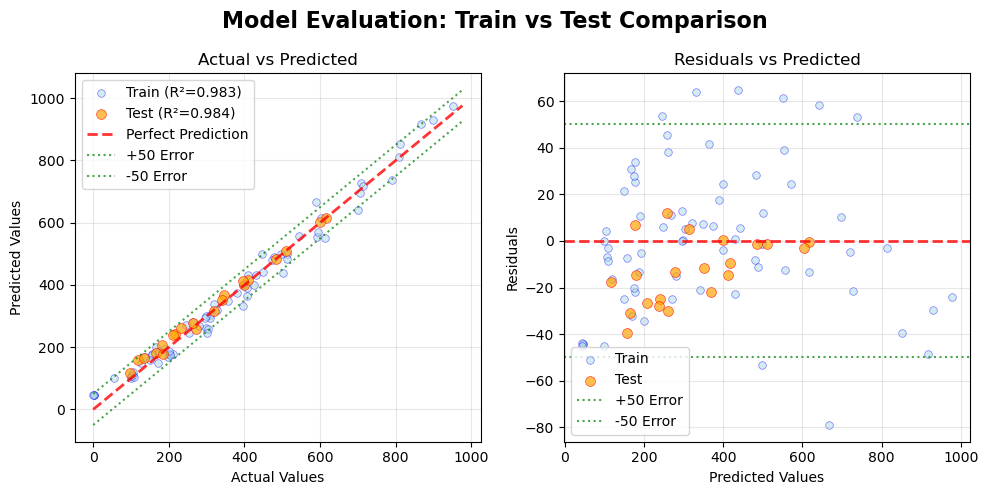

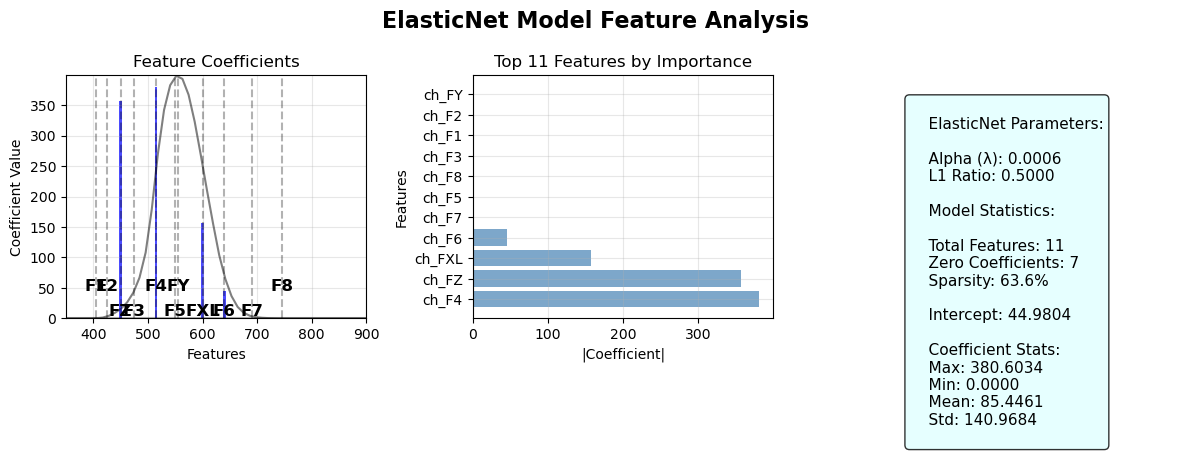

In [63]:

from train import create_pipeline, evaluate_pipeline

#sub = avg[avg.colortemp == 2500]
sub = avg.copy()

est = create_pipeline()
pipeline, features = evaluate_pipeline(est, sub)
None

In [54]:
pipeline.steps[0][1]

MinMaxScaler()

In [77]:
from luxmeter_core import AS7343_CHANNEL_MAP


def export_model(out, pipeline, features):

    scaler = pipeline.named_steps['scaler']
    regressor = pipeline.named_steps['regressor']
    assert len(pipeline.named_steps) == 2, pipeline.named_steps
    
    # We adapt the model to respect the original ordering/number of channels
    # Unused features will just be zeroed
    all_channels = AS7343_CHANNEL_MAP
    n_channels = len(all_channels)
    scale_min = numpy.zeros(n_channels)
    scale_mul = numpy.zeros(n_channels)
    regressor_weights = numpy.zeros(n_channels)
    
    for channel_idx, channel in enumerate(all_channels):
        feature = 'ch_'+channel
        if feature not in features:
            #print('Unused', channel, feature)
            continue
        feature_idx = features.index(feature)
        scale_min[channel_idx] = scaler.min_[feature_idx]
        scale_mul[channel_idx] = scaler.scale_[feature_idx]
        regressor_weights[channel_idx] = regressor.coef_[feature_idx]

    # Duplicate bias just to make it compatible in shape with the rest
    regressor_bias = numpy.array([regressor.intercept_] * n_channels)
    
    combined = numpy.stack([ scale_min, scale_mul, regressor_bias, regressor_weights ]).astype(float)
    print(combined)
    
    numpy.save(out, combined)

out_path = 'pipeline.npy'
export_model(out_path, pipeline, features)

[[-5.96872389e-04 -5.56452062e-04 -6.57198145e-04  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -3.38094836e-04 -2.78102230e-04
  -6.74698795e-04 -7.76372400e-04  0.00000000e+00  0.00000000e+00
  -1.68947457e-04 -6.67705319e-04 -1.46052031e-03 -5.25348043e-04
   0.00000000e+00  0.00000000e+00]
 [ 1.19374478e-04  5.56452062e-05  7.30220161e-05  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.69047418e-04  5.56204461e-05
   9.63855422e-05  6.46977000e-05  0.00000000e+00  0.00000000e+00
   1.68947457e-04  5.56421099e-05  1.82565039e-04  1.75116014e-04
   0.00000000e+00  0.00000000e+00]
 [ 4.49803623e+01  4.49803623e+01  4.49803623e+01  4.49803623e+01
   4.49803623e+01  4.49803623e+01  4.49803623e+01  4.49803623e+01
   4.49803623e+01  4.49803623e+01  4.49803623e+01  4.49803623e+01
   4.49803623e+01  4.49803623e+01  4.49803623e+01  4.49803623e+01
   4.49803623e+01  4.49803623e+01]
 [ 3.56733211e+02  0.00000000e+00  1.57273625e+02  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.